In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
train = pd.read_parquet(
    "s3://ling583/wine-train.parquet", storage_options={"anon": True}
)
test = pd.read_parquet("s3://ling583/wine-test.parquet", storage_options={"anon": True})

In [3]:
import cloudpickle
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

In [5]:
sgd = cloudpickle.load(open("sgd.model", "rb"))

In [6]:
predicted = sgd.predict(test["review_text"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.69      0.82      0.75      7558
        Chardonnay       0.83      0.85      0.84      4861
            Merlot       0.84      0.33      0.48      1381
        Pinot Noir       0.76      0.88      0.81      9618
          Riesling       0.81      0.79      0.80      2421
   Sauvignon Blanc       0.85      0.66      0.74      1278
             Syrah       0.76      0.53      0.63      3426
         Zinfandel       0.87      0.51      0.64      2082

          accuracy                           0.76     32625
         macro avg       0.80      0.67      0.71     32625
      weighted avg       0.77      0.76      0.75     32625



Just as a continuation of notebook 1, this classification report is significant because, essentially, the linear model comes up with a score for each of these possible classes, and for whichever class receives the highest score, that's the class the model predicts. I want to build on this to find words my model is using to predict labels.

# Words for Predicting Labels, Model Coefficients

In [10]:
# chunks of code pulled from lab 7 (notebook 3: decision function, model parameters)

labels = sgd.named_steps['sgdclassifier'].classes_
vocab = sgd.named_steps['countvectorizer'].get_feature_names()
coef = sgd.named_steps['sgdclassifier'].coef_

In [8]:
labels, coef

(array(['Cabernet Sauvignon', 'Chardonnay', 'Merlot', 'Pinot Noir',
        'Riesling', 'Sauvignon Blanc', 'Syrah', 'Zinfandel'], dtype='<U18'),
 array([[ 0.8527718 , -0.47901591, -0.24213969, ..., -0.0750112 ,
         -0.00307523, -0.08787666],
        [-0.06950993, -0.25563047,  0.03887455, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00233178, -0.03522086,  0.01347045, ...,  0.12528136,
          0.        ,  0.03675197],
        ...,
        [-0.13637028, -0.11302926,  0.23605163, ...,  0.        ,
          0.        ,  0.        ],
        [-0.18765431,  0.35583836,  0.15084316, ..., -0.19554465,
         -0.07266896,  0.        ],
        [ 0.01940718,  0.28046488,  0.06641546, ..., -0.00817224,
          0.        ,  0.        ]]))

Below consists of words my model uses for predicting wine labels.

In [9]:
ranked = np.argsort(coef, axis=1)
for i, label in enumerate(labels):
    print(label)
    for j in concat([range(-1, -11, -1), range(10, 0, -1)]):
        print(f'  {vocab[ranked[i,j]]:15s} {coef[i, ranked[i,j]]:6.3f}')
    print()

Cabernet Sauvignon
  cab             12.865
  cabernet        11.472
  cabs             8.572
  cassis           8.060
  bordeaux         5.519
  currant          5.195
  napa             5.014
  tannins          4.738
  bell             4.266
  caymus           4.192
  chard           -3.355
  zins            -3.502
  pinots          -3.517
  merlots         -3.747
  chardonnay      -3.860
  zinfandel       -4.131
  burgundy        -4.382
  zin             -6.638
  syrah           -7.631
  pinot           -8.332

Chardonnay
  chardonnay      11.235
  chard            9.147
  chablis          8.066
  buttery          6.477
  butter           6.409
  chards           6.149
  chardonnays      5.566
  meursault        5.548
  butterscotch     4.725
  premox           4.534
  cherries        -3.774
  sweetness       -3.815
  dark            -3.913
  sb              -4.210
  red             -4.356
  pinot           -4.377
  sauvignon       -4.663
  tannins         -5.513
  riesling        -

In [12]:
from kwic import kwic

In [13]:
kwic('bacon', train['review_text'])

53,"good syrah, really pretty good but not great. has that nice fruit and",bacon,fat flavor but almost comes across as artificially flavored
104,"of cherry, black pepper, rose and dusty. It's balanced and has flavours of",bacon,and cherry with a medium/full body. Round texture with a medium finish - B
136,"What an awesome wine! Rich and powerful, with notes of leather,",bacon,and game meats. The alcohol emerged sometime later. Sweet and soft on the
170,h fruit and an earthy spiciness with some faint stemmy notes. Enjoyed with,bacon,"-wrapped pork shoulder slow roasted. Didn't really open day two, became mor"
232,"Popped and poured, nose of",bacon,", smoke and floral. Tart berry taste with a long bacon fat finnish. Just an"
232,"and poured, nose of bacon, smoke and floral. Tart berry taste with a long",bacon,fat finnish. Just an out of balance wine for me. Will save for 24 hours an
420,"Odd meaty smell,",bacon,", prune, a little medicinal or perfumy. Similar in taste but some sourness."
479,"A nice wine, from Domaine lands I think. Nose showed smoked",bacon,", a touch of rubber, red cherries, earth and meat with some pretty flowers"
585,"ue, watery edges. Nose is a little tight with a hint of cherries, game and",bacon,"fat. The attack is somewhat fruity with nice acidity. From there, it goes"
682,"Meat,",bacon,", tar on an odd nose. A bit of tire rubber on the palate, finishing with a"


In [24]:
train['review_text'][136]

'What an awesome wine! Rich and powerful, with notes of leather, bacon and game meats. The alcohol emerged sometime later. Sweet and soft on the palate. Delicious.'

In [29]:
kwic('bell', train['review_text'])

152,"Purple, bright ruby color. The nose has cassis and green",bell,pepper. Lots of heat and tannins. Not much fruit on the palate. Drinks lik
283,"Great black cherry, tobacco and",bell,pepper with a nice dusty element. Considerable elegance but backed by a gr
802,"ely smooth mid-palate with soft dry tannins. Cherry, current and a hint of",bell,pepper on the palate. Maybe a little dilute and a little green but a great
1054,"h. Blackberries, black current, chocolate, sight herbaceous/bramble. Green",bell,"pepper came out after an hour. Big long, grippy finish."
1779,"s a deep purple, and the aromas are blackberry, pencil lead, chocolate and",bell,"pepper. The flavors are blackberry, currant, chocolate. This a a full bodi"
2207,l cycles and a few days of 85+ degree temps? Loads of dark fruit with some,bell,pepper accents and a little caramel. Acidity shows on attack with a creamy
2334,"Color: mostly opaque, ruby color throughout. Nose: hatch or",bell,"pepper, ripe fruit. Taste: blackberry, sage, anise, mulberry. Comments: tr"
2575,"this bottle quite disappointing. Nose didn't give much, but had aromas of",bell,"pepper, white pepper, and orange peel. The body was lacking. No backbone."
2712,"a deep purple, as expected. Not giving much on the nose but for some green",bell,"pepper and alcohol, which is almost strong enough to make you sneeze. Pala"
2957,"Blackberry, earth,",bell,pepper and barnyard. Good balance. Soft finish that is lacking in complexi


In [26]:
kwic('diesel', train['review_text'])

252,d blind I think everyone would have guessed nearly 10yrs younger. A bit of,diesel,"on the nose, lemon cream, white flowers very dry but a hint of sweetness."
504,"ing explosive aromas of spices, apricots, Mandarin oranges (and a whiff of",diesel,"fuel). Medium-bodied on the palate, with crisp acidity and similar flavor"
2217,Wow! Nose full of,diesel,- beautiful on the palate. In a blind tasting would pass for really good G
2437,w was this drinking well tonight. Light golden yellow color with aromas of,diesel,"and baked apple. Terrific fruit and diesel qualities on the palate, viscou"
2437,den yellow color with aromas of diesel and baked apple. Terrific fruit and,diesel,"qualities on the palate, viscous texture and a long finish, but with plent"
2625,"inky black in the glass. The nose is dark brooding cassis, wet forest and",diesel,in a good way. The fruit is vibrant and ripe blackberry wrapped in some so
3304,"Clear, light gold, citrus, apricot, mineral on the nose and pronounced",diesel,at the begining. High acidity & crispy. Medium finish. Easy to approach no
4302,"of Pfalz-like yellow and orange fruits, while carrying a distinctive Mosel",diesel,-- neither of which I ever recall finding in an Austrian riesling. Drink u
4986,Golden color. Typical riesling,diesel,aroma with a bit of lemon underneath. Lemon dominates on the tongue with a
5191,"Wonderful riesling nose with apricot, stonefruit, and",diesel,"backbone, mouthfilling and long on the palate, this classic auslese drank"


In [28]:
kwic('kerosene', train['review_text'])

842,icer with some interesting green pepper and more robust fruit. First night,kerosene,and battery acid with hints of...egad...I think it might be burnt rubber.
842,"th hints of...egad...I think it might be burnt rubber. Second night, still",kerosene,but black cherries show up with some medium tannnins. I suggest opening th
1488,Nice golden color. Nose of,kerosene,", lemon oil, golden delicious apples, asian pear, dried pineapple, apricot."
1812,"more mature, slightly musky manuka honey tones. There was actually tons of",kerosene,"on the palate, so much more than the hints of it on the nose, along with a"
3252,Med yellow gold - lovely nose of,kerosene,", lanolin, lime leaves - tastes wonderful, v well balanced - citrus, minera"
4526,"Very nice, bright, yellow hue,",kerosene,"/petrolly nose, mid palate seemed a little thin/watery. I was hoping for m"
5117,"llow/green with perfect clarity. Nose of white peach, limes and a touch of",kerosene,"and lanolin. Palate is a sheer, breathtaking edifice of citrus, white peac"
6818,as for s-b rather dark but nice. nose -,kerosene,", fennel. black currant!!!. taste: very elegant and oily, nice accidity - b"
7097,"Pale lemon, green tints, some spritz. Good intensity on nose,",kerosene,"and lime with mineral notes. Medium dry, with medium + acidity. Good depth"
7097,"dry, with medium + acidity. Good depth on palate with lime prominent, also",kerosene,"and mineral notes. Good persistent finish, balanced and light. Good qulity"


In [30]:
kwic('petrol', train['review_text'])

14,Starting to become golden in color. Interesting nose with scents of,petrol,or modeling glue. Crisp but with enough sweetness to balance the acid flav
112,Medium golden yellow color;,petrol,", mineral, vanilla bean, creamy nose; petrol, tart stone fruit, mineral pal"
112,"Medium golden yellow color; petrol, mineral, vanilla bean, creamy nose;",petrol,", tart stone fruit, mineral palate; medium finish"
143,"Rich and minerally, this has subtle mature",petrol,"notes, crisp acidity and nice delineation on the finish."
237,"to make of this on the palate though -- bone dry, a riesling taste, but no",petrol,", no hint of residual sweetness, and a marked but pleasant acidity. Very in"
345,"ght, the garden variety Hugel Rieslnig was third best in the blind flight.",Petrol,"blew off leaving brown sugar, a little nuttiness. Very pale color. A touch"
350,"m glad I tried it, I won't be revisiting it. The nose gives off a touch of",petrol,"and burnt rubber, and the attack (somewhat to my surprise) is almost as sy"
383,"Light straw-lemon. Medium nose of tropical fruits,",petrol,", yellow plum, quetsch. Off-dry, medium acidity and ditto sweetness. Fruit-"
396,e fruit in a fairly straightforward way with a medium level of acidity. No,petrol,"notes, but some minerality on the finish. Less sweet than many Spatlese."
407,Pretty lemon cream aroma with just a hint of,petrol,that passes with air. Smoke & more smoke over lemon citrus flavors & charr


As you'd expect, words that are essentially the wine variety itself (variations on how to refer to that wine) are all strongly correlated with that corresponding label. Pragmatically, and I suppose holistically, that doesn't really do anything aside from take up space in the list of words used to predict these labels. I'd think being able to combine those variations into a single label (or topic..) would be more useful, with more room to focus on the actual tasting notes of a wine type: what is and isn't considered "highly-influential" for that label.

Getting away from me a bit, but if you had, say, coffee tasting notes of "plum," "tapioca," and "berry lemonade," you might get somewhere and label that under "Myanmar," but if you said "Lay Ywar," I don't think most people would even know if that's the coffee name, the name of the farm, or some sort of region in Myanmar. That's what I'd prioritize for improving the classification functionality.

I think my model is generally sensitive to actual tasting notes from the review texts. A good example would be Pinot Noir, which has fairly large positive coefficients for "cherry," "cola," "strawberry," and also a fairly strong negative coefficient for "lemon." 

In [32]:
kwic('zins', train['review_text'])

129,I think one of the best,zins,"made. Not overly ripe which is what I like. Herbal tone, maybe a green str"
129,"ke. Herbal tone, maybe a green streak in this, but I get that from all V29",Zins,". a complex wine that has rich, well balanced fruit."
480,lly aged and evolved gracefully. One of the most elegant and well-balanced,zins,I've had. Remarkable how much it has developed over the last couple of yea
502,rry and strawberry. Mouthfeel is lush. Decent finish. Less spicy than some,zins,and probably less complex than the 07 that we've enjoyed so much. Still a
799,over 2 hours. Went great with grilled NY strips. One of the great QPRs in,Zins,. Glad I have more!
926,amon in a med-bodied package. This is not as oaky or jammy as some Stryker,Zins,but the balance as nice. Could use a little more time to fully integrate t
930,"e loves Turley of any kind. For the price, this is a great Zin if you like",zins,.
951,"I was expecting, which was a zin that I would like even more than the Sin",Zins,"of past vintages. This one seemed too light weight for me, but others coul"
1002,ce on palate. Great acidity on finish. Good consistency from this winery's,Zins,from vintage to vintage.
1071,nk this Zin is over priced. it is thin and watery. I can think of several,Zins,at half the price i'd rather drink.


However, as of right now, it seems that a word like "zins" is more significant than the actual words associated with it, which is likely the reason for Zinfadel not being a good example for a label that is actually constructed by tasting notes, unlike Pinot Noir. Perhaps the issue is that the words used to describe "zins" don't occur all that often, like "herbal," "fruit," and "strawberry" (another side note: "fruit" is a silly note when you also refer to berries...but "fruity" is surprisingly better and acceptable—maybe the former point can lead to more classification considerations).

I would say that there is evidence of overfitting for words that are actually locations and wineries. Off the top of my head, Napa Valley and Bordeaux are regions that produce all sorts of wine, not just Cabernet Sauvignon, yet they're both of higher coefficients for that wine type. "Havens" is also a winery that produces much more than just Merlot, yet is more strongly-correlated with Merlot.

# Decision Function (model improvements by exclusion)

In [66]:
import matplotlib.pyplot as plt

In [67]:
labels

array(['Cabernet Sauvignon', 'Chardonnay', 'Merlot', 'Pinot Noir',
       'Riesling', 'Sauvignon Blanc', 'Syrah', 'Zinfandel'], dtype='<U18')

In [68]:
scores = sgd.decision_function(test["review_text"])
highest = scores.max(axis=1)

In [85]:
# sorting labels so that the top score is in the far-right column
# where the label with the second-highest score is second from the right
scores.sort(axis=1) 
scores[0:5,:]

array([[-1.25150212, -1.23444208, -1.18798125, -1.17018853, -1.16159786,
        -1.1490505 , -1.05546534, -0.61480536],
       [-2.40842032, -2.14353095, -1.7742371 , -1.51103225, -1.40951584,
        -1.14054332,  0.60494363,  0.61508974],
       [-1.88830505, -1.80145615, -1.76058877, -1.59022103, -1.34892105,
        -1.24733625, -1.11468393,  0.82014463],
       [-4.16585668, -3.50860832, -2.29509456, -1.62099501, -1.45131956,
        -1.07445286, -0.97668276,  1.31510325],
       [-4.00960973, -3.66850803, -2.71981766, -2.03729788, -1.87131567,
        -1.78535965, -1.31918713,  3.95217354]])

Due to sorting, the labels themselves are now scattered, but this is fine for tasks such as examining margins and determining the number of examples for exclusion to raise the F1 score to desired levels (based off of margins).

In [88]:
margin = scores[:,7]-scores[:,6]

In [91]:
margin.max(), margin.min()

(12.565631483255588, 0.0001101524075651783)

Text(0, 0.5, 'F1')

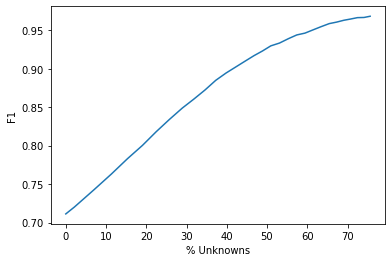

In [90]:
thresh = np.linspace(-2, 3, 50)
x = [100*(1-sum(margin > t)/len(margin)) for t in thresh]
y = [f1_score(test["wine_variant"][margin > t], predicted[margin > t], average="macro") for t in thresh]
plt.plot(x, y)
plt.xlabel('% Unknowns')
plt.ylabel('F1')

Based off of this threshold plot, if I wanted to achieve an F1 score greater than .85 for this model, I would ideally exclude around 30% of the unknowns at a minimum. 